In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# download dataset

🐟
**sea animal dataset:**



*   n01910747: jellyfish
*   n09256479: coral reef
*   n01498041: stingray
*   n01496331: electric ray, crampfish, numbfish, torpedo

---

🚌
**public transportation dataset:**

*   n02691156: airplane
*   n04552348: warplane, military plane
*   n03095699: container ship, containership, container vessel
*   n04335435: streetcar, tram, tramcar, trolley, trolley car



In [ ]:
# !git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git

In [ ]:
# %cd /content/drive/MyDrive/NeuralNetwork/ImageNet-Datasets-Downloader

In [ ]:
# !python downloader.py \
#     -data_root /content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/c \
#     -use_class_list True \
#     -class_list n01917289 \
#     -images_per_class 200

In [ ]:
# !unzip "/content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/sea_animals/imagenet_images.zip" -d "/content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/sea_animals"

In [ ]:
# !unzip "/content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/vehicle_trans/imagenet_images.zip" -d "/content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/vehicle_trans"

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from keras import backend as K

from sklearn.model_selection import KFold

import numpy as np
from numpy import linalg as LA
from itertools import product
import scipy
import random

import os
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm


# Constant values

In [3]:
# dimension of input image
rows, cols= 200, 200

# number of neurons as number of Rule will be produce
n_neurons = 100

# number of features feed to fuzzy Inference Layer
n_feature = 9

# based of article
batch_size = 70

# Preprocessing On Dataset

## Define its Function

function to show number of images per class

In [4]:
def count_samepes_perclass(train):
    train_ds = train.unbatch()
    images = list(train_ds.map(lambda x, y: x))
    labels = list(train_ds.map(lambda x, y: y))

    labels = np.array(labels)
    print(len(labels[labels==0]))
    print(len(labels[labels==1]))
    print(len(labels[labels==2]))
    return images, labels


function to load dataset

In [5]:
def load_data(address_ds, size_batch):
    # size of the dataset
    batch_size = size_batch

    train_ds = tf.keras.utils.image_dataset_from_directory(
      address_ds,
      seed=123,
      image_size=(rows, cols),
      batch_size=batch_size)
    
    return train_ds

## call functions

load dataset

In [6]:
# sea animal dataset
train_ds = load_data('/content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/sea_animals/imagenet_images', 2019)

Found 2019 files belonging to 3 classes.


In [ ]:
# public transportation dataset
transportation_ds = load_data('/content/drive/MyDrive/NeuralNetwork/final_project/dataset/set3/imagenet_images/vehicle_trans/imagenet_images', 2097)

Check the number of samples per class

In [ ]:
# count_samepes_perclass(train_ds)
# count_samepes_perclass(transportation_ds)

Name of each class

In [7]:
# sea animal dataset
class_names = train_ds.class_names
print('animal dataset:{}'.format(class_names))

animal dataset:['coral fungus', 'jellyfish', 'stingray']


In [ ]:
# public transportation dataset
class_names_transportation_ds = transportation_ds.class_names
print('animal dataset:{}'.format(class_names_transportation_ds))

animal dataset:['airplane', 'container ship', 'streetcar']


convert elements of dataset to numpy array to ease implementation of k-fold process

In [8]:
# sea animal dataset
for image, label in train_ds.take(1):
    train_images = image.numpy()
    train_labels = np.reshape(label.numpy(), (-1,1))

del train_ds
del class_names
gc.collect

<function gc.collect>

In [ ]:
# public transportation dataset
for image, label in transportation_ds.take(1):
    train_transportation_images = image.numpy()
    train_transportation_labels = np.reshape(label.numpy(), (-1,1))

del transportation_ds
del class_names_transportation_ds
gc.collect

<function gc.collect>

## Investigate in Dataset

#### sea anmals

In [ ]:
# shape of the training set
print("train_images", train_images.shape)
print("test_images", train_labels.shape)

train_images (2019, 200, 200, 3)
test_images (2019, 1)


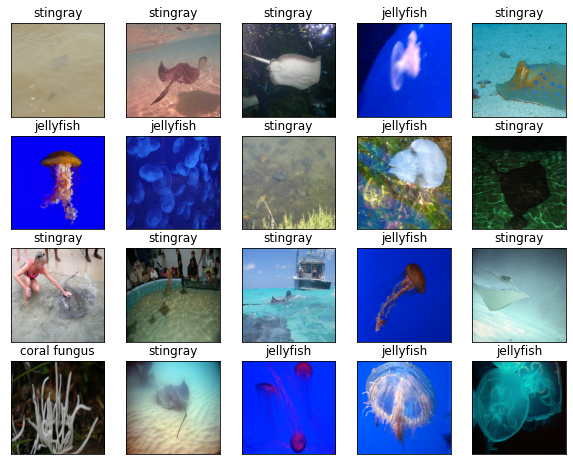

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(class_names[(train_labels[i][0])])
    plt.xticks([])
    plt.yticks([])
plt.show()

#### transportaiton

In [ ]:
# shape of the training set
print("train_images", train_transportation_images.shape)
print("test_images", train_transportation_labels.shape)

train_images (2097, 200, 200, 3)
test_images (2097, 1)


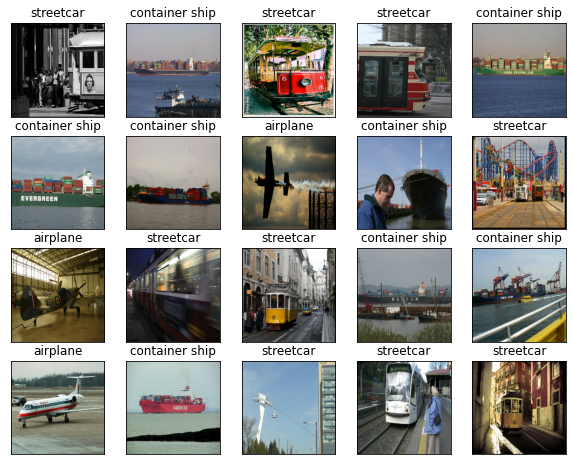

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_transportation_images[i].astype("uint8"))
    plt.title(class_names_transportation_ds[(train_transportation_labels[i][0])])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Normalize images

In [9]:
# public transportation dataset
normalized_train_images = train_images / 255.0
del train_images
gc.collect

<function gc.collect>

In [ ]:
# public transportation dataset
normalized_train_transportation_images = train_transportation_images / 255.0
del train_transportation_images
gc.collect

<function gc.collect>

check range of normalized image after process

In [ ]:
first_image = normalized_train_transportation_images[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Implement Fuzzy block (Inference)

define dimension of rules and some sort of permutation of mu in different rules

In [10]:
# to get all permutaion
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 

# based on article just 100 of them are needed
out_fRules = random.sample(fRules, n_neurons)

fRules_sigma = K.transpose(out_fRules)

define classe of fuzzy layer

In [11]:
class fuzzy_inference_block(tf.keras.layers.Layer):
    def __init__(self, output_dim, i_fmap, mu, sigma):

        self.output_dim = output_dim
        self.index = i_fmap
        self.mu = mu
        self.sigma = sigma

        super(fuzzy_inference_block, self).__init__()

    def build(self, input_shape):
        self.mu_map = fRules_sigma * self.mu
        self.sigma_map = tf.ones((n_feature, self.output_dim)) * self.sigma
        

        super().build(input_shape)

    def call(self, inputs):
        fMap = inputs[:,n_feature*(self.index):n_feature*(self.index+1)]
        # create variables for processing
        aligned_x = K.repeat_elements(K.expand_dims(fMap, axis=-1), self.output_dim, -1)
        aligned_c = self.mu_map
        aligned_s = self.sigma_map


        # calculate output of each neuron (fuzzy rule)
        phi = K.exp(-K.sum(K.square(aligned_x - aligned_c) / (2 * K.square(aligned_s)),
                           axis=-2, keepdims=False))
        return phi


# Implement Fuzzy CNN

define fuzzy CNN architecture

In [12]:
def fcnn(img_path='network_image.png', n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=True):
    # if stride is 3 => size of feature map will be 2x2
    # elif stride is 2 => size of feature map will be 3x3

    num_classes = 3

    inp = Input(shape=[rows, cols, 3])

    conv1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inp)
    conv1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv1)

    conv2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(conv1)
    conv2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv2)

    conv3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv2)
    conv3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv3)

    conv4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv3)
    conv4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv4)

    conv5 = Conv2D(n_femap, (4, 4), padding='same', strides=(stride,stride), activation='relu')(conv4)
    if dropout:
       conv5 = Dropout(0.2)(conv5)

    fMaps = Flatten()(conv5)


    fuzzy_inference = []
    for i in tqdm(range(n_femap)):
        f_block = fuzzy_inference_block(output_dim=n_neurons, i_fmap=i, mu=mu, sigma=sigma)(fMaps)
        fuzzy_inference.append(f_block)
    merged = concatenate(fuzzy_inference, axis=1)

    out = Dense(num_classes, activation='softmax')(merged)

    model = tf.keras.Model(inp, out)

    del inp
    del conv1
    del conv2
    del conv3
    del conv4
    del conv5
    del f_block
    del fuzzy_inference
    del merged
    del out
    gc.collect()
    # plot_model(model, to_file=img_path)

    return model

define CNN architecture

In [13]:
def cnn(img_path='network_image.png', n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=False):
    num_classes = 3

    inputs = tf.keras.layers.Input(shape=[rows, cols, 3])

    tower_1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inputs)
    tower_1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(tower_1)

    tower_2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(tower_1)
    tower_2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_2)

    tower_3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(tower_2)
    tower_3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_3)

    tower_4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(tower_3)
    tower_4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_4)

    tower_5 = Conv2D(80, (4, 4), padding='same', strides=(3,3), activation='relu')(tower_4)
    tower_5= Dropout(0.2)(tower_5)

    tower_5 = Flatten()(tower_5)

    out = Dense(100, activation='relu')(tower_5)
    out = Dense(num_classes, activation='softmax')(out)

    model = tf.keras.Model(inputs, out)
    # plot_model(model, to_file=img_path)
    return model

# Show Model

100%|██████████| 80/80 [00:01<00:00, 56.81it/s]


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.950071 to fit



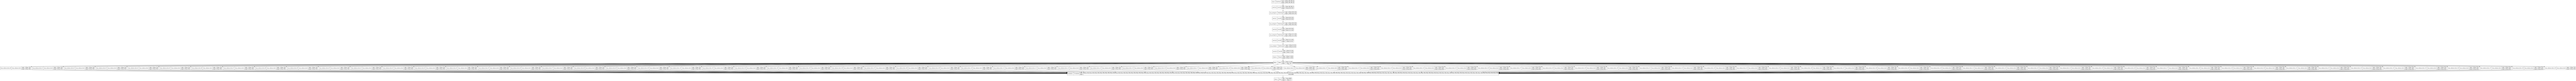

In [ ]:
model = fcnn(n_femap=80)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

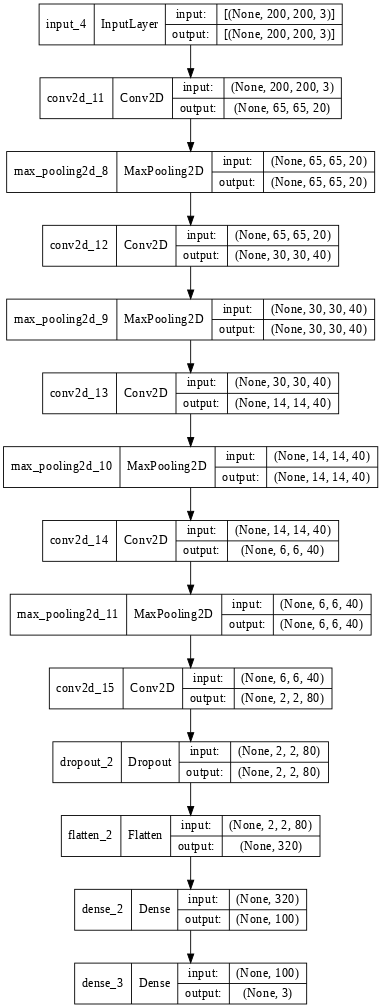

In [ ]:
base_model = cnn()
tf.keras.utils.plot_model(base_model, show_shapes=True, dpi=64)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 65, 65, 20)   2180        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 65, 65, 20)  0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 30, 30, 40)   28840       ['max_pooling2d_4[0][0]']  

In [ ]:
base_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 65, 65, 20)        2180      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 65, 65, 20)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 40)        28840     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 40)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 40)        1444

In [ ]:
# np.array(fRules).reshape((-1,3,3)).shape

In [ ]:
# 3**9*80

In [ ]:
# 3**4*10

# Run the Model

### functions to show results

In [14]:
def show_result(foldperf, scores, nmodel, num_epochs):
    # number of folds
    k=10

    for i, score in enumerate(scores):
        print('Performance of {} fold cross validation'.format(k))
        print("Average model{} Loss: {:.3f}, Average model{} Acc: {:.2f}".format(nmodel[i], np.mean(score[0]) ,nmodel[i] , np.mean(score[1])))


    losses = np.zeros((len(foldperf), num_epochs))
    accs = np.zeros((len(foldperf), num_epochs))

    for j in range(len(foldperf)):
      for i in range(num_epochs):
          losses[j, i] = np.mean([foldperf[j]['fold{}'.format(f+2)].history['loss'][i] for f in range(k)])
          accs[j, i] = np.mean([foldperf[j]['fold{}'.format(f+2)].history['sparse_categorical_accuracy'][i] for f in range(k)])

    # Plot losses
    plt.figure(figsize=(10,8))
    for i in range(len(losses)):
        plt.semilogy(losses[i], label=nmodel[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('loss')
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(10,8))
    for i in range(len(accs)):
        plt.semilogy(accs[i], label=nmodel[i])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

### function to train model

In [15]:
kfold = KFold(n_splits=10, shuffle=True)

In [16]:
def train_model(model_func, train_images, train_labels, no_epochs=30, optimizer='adam', n_femap=80, stride=2, mu=3.0, sigma=1.2, dropout=True, show=True):
    foldperf = {}
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []

    model = scores = history = 1

    for test, train in kfold.split(train_images, train_labels):


        del history
        del scores
        del model

        tf.keras.backend.clear_session()

        gc.collect()

        # Define the model architecture 
        model = model_func(n_femap=n_femap, stride=stride, mu=mu, sigma=sigma, dropout=dropout)
        # Compile model
        model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit on data for 30 epochs
        history = model.fit(train_images[train], train_labels[train],
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=show)

        # Generate generalization metrics
        scores = model.evaluate(train_images[test], train_labels[test], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

        foldperf['fold{}'.format(fold_no)] = history  

        # gc.collect()

        

    return foldperf, [loss_per_fold, acc_per_fold]

### To test functions

In [ ]:
foldperf_temp, scores_temp = train_model(fcnn, normalized_train_images, train_labels,no_epochs=10, show=False)

100%|██████████| 80/80 [00:01<00:00, 51.38it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.0889972448349; sparse_categorical_accuracy of 52.44908928871155%


100%|██████████| 80/80 [00:01<00:00, 54.14it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.0863828659057617; sparse_categorical_accuracy of 50.6879448890686%


100%|██████████| 80/80 [00:01<00:00, 54.61it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1.087712287902832; sparse_categorical_accuracy of 34.50742959976196%


100%|██████████| 80/80 [00:01<00:00, 54.78it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 1.0910027027130127; sparse_categorical_accuracy of 34.17721390724182%


100%|██████████| 80/80 [00:01<00:00, 52.61it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.0880576372146606; sparse_categorical_accuracy of 34.39735770225525%


100%|██████████| 80/80 [00:02<00:00, 27.97it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 1.0852793455123901; sparse_categorical_accuracy of 58.99834632873535%


100%|██████████| 80/80 [00:01<00:00, 53.72it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 1.0854088068008423; sparse_categorical_accuracy of 39.240506291389465%


100%|██████████| 80/80 [00:01<00:00, 54.24it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 1.0909544229507446; sparse_categorical_accuracy of 34.23224985599518%


100%|██████████| 80/80 [00:01<00:00, 53.23it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 1.0849517583847046; sparse_categorical_accuracy of 34.34232175350189%


100%|██████████| 80/80 [00:01<00:00, 53.84it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 1.0877553224563599; sparse_categorical_accuracy of 45.32453119754791%


In [ ]:
foldperf_temp_cnn, scores_temp_cnn = train_model(cnn, normalized_train_images, train_labels,no_epochs=10, show=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.5735225081443787; sparse_categorical_accuracy of 82.346111536026%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.4337219297885895; sparse_categorical_accuracy of 82.22996592521667%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.6350489258766174; sparse_categorical_accuracy of 64.69221711158752%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.6337375044822693; sparse_categorical_accuracy of 68.29268336296082%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.5922699570655823; sparse_categorical_accuracy of 79.21022176742554%
-------------------------------------

Performance of 10 fold cross validation
Average FCNN Loss: 1.088 	 Average CNN Loss: 0.475 	 Average FCNN Acc: 41.84 	 Average CNN Acc: 81.56


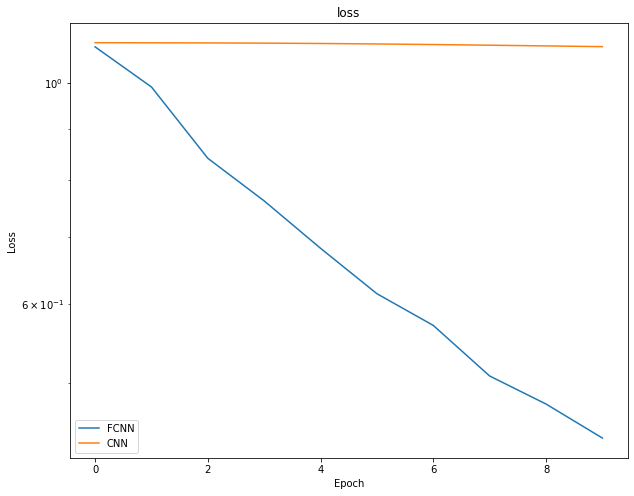

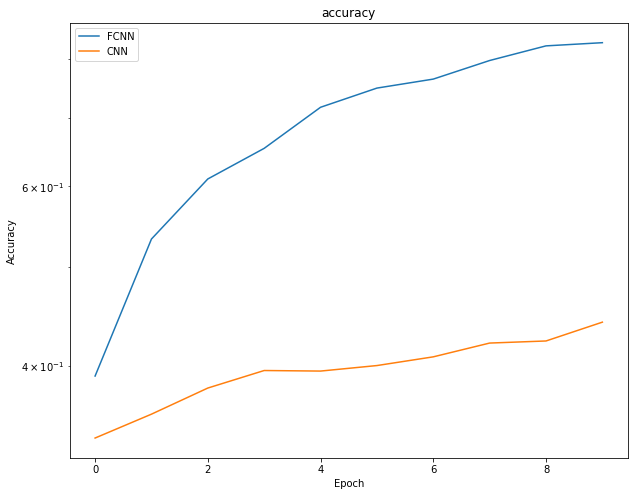

In [ ]:
show_result(scores_temp, foldperf_temp, scores_temp_cnn, foldperf_temp_cnn, num_epochs=10)

Performance of 10 fold cross validation
Average FCNN Loss: 0.475 	 Average CNN Loss: 0.475 	 Average FCNN Acc: 81.56 	 Average CNN Acc: 81.56


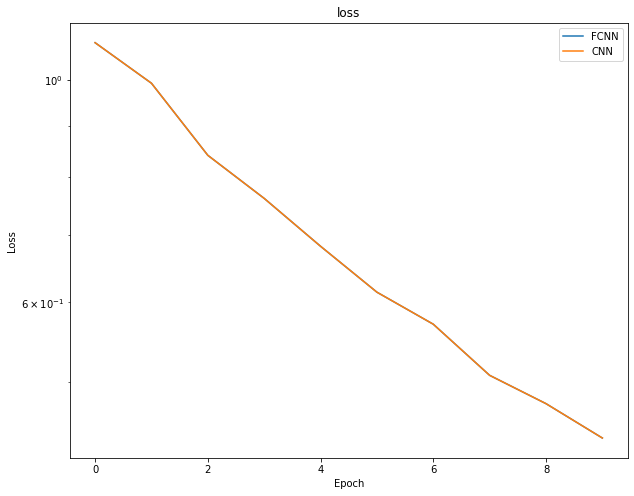

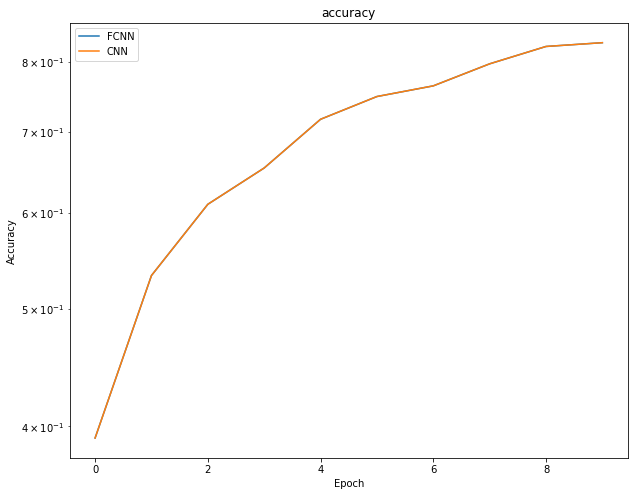

In [ ]:
show_result(0, 0, scores_temp_cnn, foldperf_temp_cnn, num_epochs=10, cnn=True, fcnn=False)

### base model

In [ ]:
num_epochs= 1200

FCNN

100%|██████████| 80/80 [00:01<00:00, 55.40it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.8043999671936035; sparse_categorical_accuracy of 86.07594966888428%


100%|██████████| 80/80 [00:01<00:00, 55.65it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.831017017364502; sparse_categorical_accuracy of 85.80077290534973%


100%|██████████| 80/80 [00:01<00:00, 54.20it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5514946579933167; sparse_categorical_accuracy of 84.14969444274902%


100%|██████████| 80/80 [00:01<00:00, 54.46it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.807468831539154; sparse_categorical_accuracy of 86.2960934638977%


100%|██████████| 80/80 [00:01<00:00, 57.41it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.097509503364563; sparse_categorical_accuracy of 34.61750149726868%


100%|██████████| 80/80 [00:01<00:00, 54.76it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 1.1003401279449463; sparse_categorical_accuracy of 34.39735770225525%


100%|██████████| 80/80 [00:01<00:00, 55.07it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.9260017275810242; sparse_categorical_accuracy of 83.92955660820007%


100%|██████████| 80/80 [00:01<00:00, 54.77it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 1.0986664295196533; sparse_categorical_accuracy of 34.39735770225525%


100%|██████████| 80/80 [00:01<00:00, 54.25it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.9606576561927795; sparse_categorical_accuracy of 85.03026962280273%


100%|██████████| 80/80 [00:01<00:00, 55.11it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.7453424334526062; sparse_categorical_accuracy of 85.80858111381531%
Performance of 10 fold cross validation
Average FCNN Loss: 0.892 	 Average CNN Loss: 0.892 	 Average FCNN Acc: 70.05 	 Average CNN Acc: 70.05


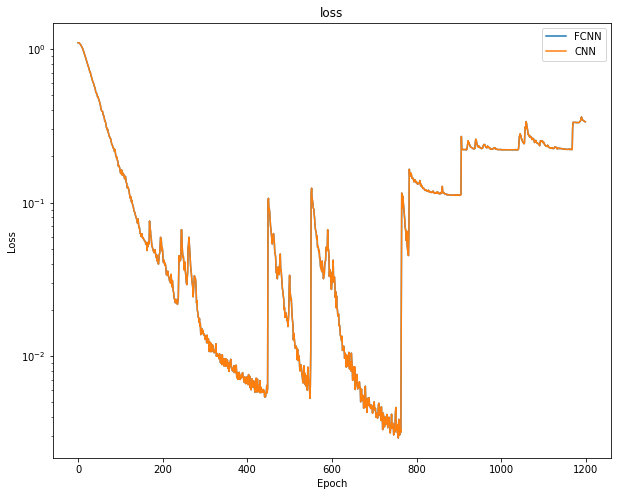

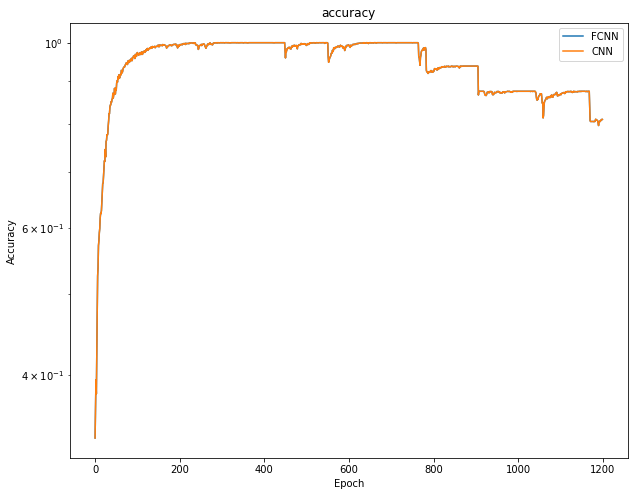

In [ ]:
fcnn_foldperf_base, fcnn_scores_base = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False)

show_result(fcnn_scores_base, fcnn_foldperf_base, 0, 0, num_epochs=num_epochs, cnn=False, fcnn=True)


CNN

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 2.268965244293213; sparse_categorical_accuracy of 82.05834031105042%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 2.3591384887695312; sparse_categorical_accuracy of 82.88387656211853%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 2.4780945777893066; sparse_categorical_accuracy of 84.14969444274902%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 3.0992865562438965; sparse_categorical_accuracy of 81.45294189453125%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.2475225925445557; sparse_categorical_accuracy of 82.44358897209167%
------------------------------------

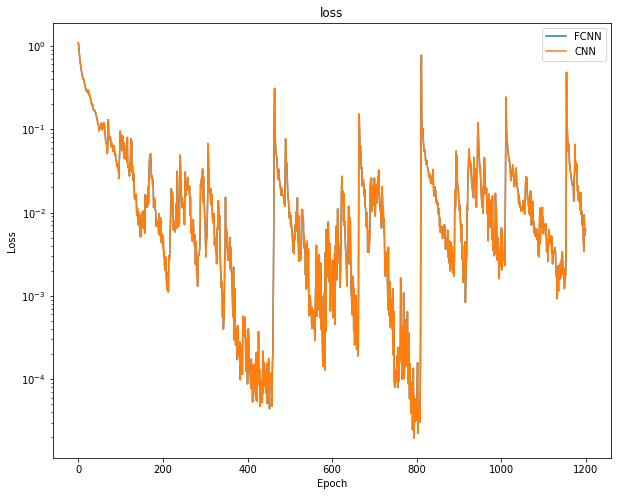

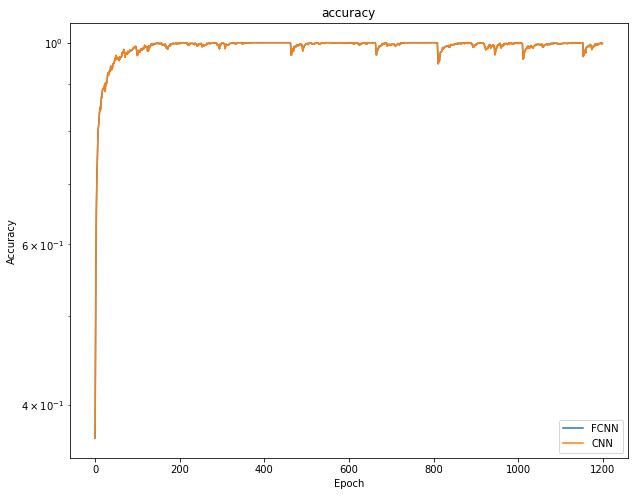

In [ ]:
cnn_foldperf_base, cnn_scores_base = train_model(cnn, normalized_train_images, train_labels,no_epochs=1500, show=False)

show_result(0, 0, cnn_scores_base, cnn_foldperf_base, num_epochs=num_epochs, cnn=True, fcnn=False)

### FCNN with different sigma

In [ ]:
num_epochs = 400

sigma = 1.5

In [ ]:
fcnn_foldperf_sg1, fcnn_scores_sg1 = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, sigma=1.5, show=False)

100%|██████████| 80/80 [00:01<00:00, 52.30it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4892514646053314; sparse_categorical_accuracy of 87.6887321472168%


100%|██████████| 80/80 [00:01<00:00, 57.57it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.4857393503189087; sparse_categorical_accuracy of 88.73403072357178%


100%|██████████| 80/80 [00:01<00:00, 56.74it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.3497081696987152; sparse_categorical_accuracy of 87.3403012752533%


100%|██████████| 80/80 [00:01<00:00, 57.56it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.6239218711853027; sparse_categorical_accuracy of 85.59814095497131%


100%|██████████| 80/80 [00:01<00:00, 56.98it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.6527036428451538; sparse_categorical_accuracy of 86.2950086593628%


100%|██████████| 80/80 [00:01<00:00, 54.57it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.3846840560436249; sparse_categorical_accuracy of 90.12776017189026%


100%|██████████| 80/80 [00:01<00:00, 57.13it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.5578448176383972; sparse_categorical_accuracy of 86.75957918167114%


100%|██████████| 80/80 [00:01<00:00, 57.42it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.3535223603248596; sparse_categorical_accuracy of 90.60325026512146%


100%|██████████| 80/80 [00:01<00:00, 57.60it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.54478919506073; sparse_categorical_accuracy of 88.39907050132751%


100%|██████████| 80/80 [00:01<00:00, 56.37it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.5985288619995117; sparse_categorical_accuracy of 85.15081405639648%


sigma = 1.2

In [ ]:
fcnn_foldperf_sg2, fcnn_scores_sg2 = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, sigma=1.2, show=False)

100%|██████████| 80/80 [00:01<00:00, 55.80it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.3300302028656006; sparse_categorical_accuracy of 90.59233665466309%


100%|██████████| 80/80 [00:01<00:00, 55.39it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.4215881824493408; sparse_categorical_accuracy of 86.41114830970764%


100%|██████████| 80/80 [00:01<00:00, 57.54it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.3937046229839325; sparse_categorical_accuracy of 88.15330862998962%


100%|██████████| 80/80 [00:01<00:00, 55.25it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.547346293926239; sparse_categorical_accuracy of 83.85598063468933%


100%|██████████| 80/80 [00:01<00:00, 56.65it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.5829152464866638; sparse_categorical_accuracy of 83.27525854110718%


100%|██████████| 80/80 [00:01<00:00, 56.87it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.370454877614975; sparse_categorical_accuracy of 87.80487775802612%


100%|██████████| 80/80 [00:01<00:00, 55.63it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.4995456039905548; sparse_categorical_accuracy of 87.80487775802612%


100%|██████████| 80/80 [00:01<00:00, 55.77it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.35185128450393677; sparse_categorical_accuracy of 89.32714462280273%


100%|██████████| 80/80 [00:01<00:00, 55.56it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.41652345657348633; sparse_categorical_accuracy of 88.39907050132751%


100%|██████████| 80/80 [00:01<00:00, 55.18it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.5041512846946716; sparse_categorical_accuracy of 81.0904860496521%


sigma = 1

In [ ]:
fcnn_foldperf_sg3, fcnn_scores_sg3 = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, sigma=1, show=False)

100%|██████████| 80/80 [00:01<00:00, 54.41it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4659300446510315; sparse_categorical_accuracy of 77.11963057518005%


100%|██████████| 80/80 [00:01<00:00, 55.45it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.4962173104286194; sparse_categorical_accuracy of 86.87572479248047%


100%|██████████| 80/80 [00:01<00:00, 54.93it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.4457698464393616; sparse_categorical_accuracy of 81.64924383163452%


100%|██████████| 80/80 [00:01<00:00, 54.71it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.43157127499580383; sparse_categorical_accuracy of 86.75957918167114%


100%|██████████| 80/80 [00:01<00:00, 55.97it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.47011399269104004; sparse_categorical_accuracy of 86.75957918167114%


100%|██████████| 80/80 [00:01<00:00, 55.42it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.42818331718444824; sparse_categorical_accuracy of 87.10801601409912%


100%|██████████| 80/80 [00:01<00:00, 55.02it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.3911513090133667; sparse_categorical_accuracy of 82.22996592521667%


100%|██████████| 80/80 [00:01<00:00, 55.48it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.4133238196372986; sparse_categorical_accuracy of 84.33874845504761%


100%|██████████| 80/80 [00:01<00:00, 54.13it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.49484896659851074; sparse_categorical_accuracy of 80.16241192817688%


100%|██████████| 80/80 [00:01<00:00, 54.40it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.44910943508148193; sparse_categorical_accuracy of 77.49419808387756%


In [ ]:
foldHist =[]
scores = []
foldHist.append(fcnn_foldperf_sg1)
foldHist.append(fcnn_foldperf_sg2)
foldHist.append(fcnn_foldperf_sg3)



scores.append(fcnn_scores_sg1)
scores.append(fcnn_scores_sg2)
scores.append(fcnn_scores_sg3)

nmodel = [' sigma=1.5', ' sigma=1.2', ' sigma=1']



Performance of 10 fold cross validation
Average model sigma=1.5 Loss: 0.504, Average model sigma=1.5 Acc: 87.67
Performance of 10 fold cross validation
Average model sigma=1.2 Loss: 0.442, Average model sigma=1.2 Acc: 86.67
Performance of 10 fold cross validation
Average model sigma=1 Loss: 0.449, Average model sigma=1 Acc: 83.05


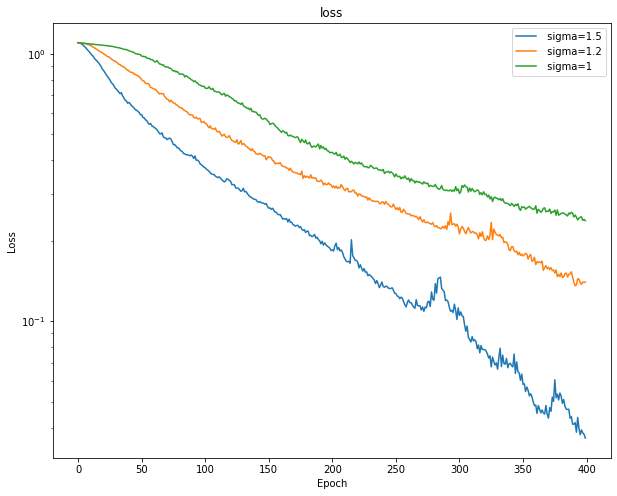

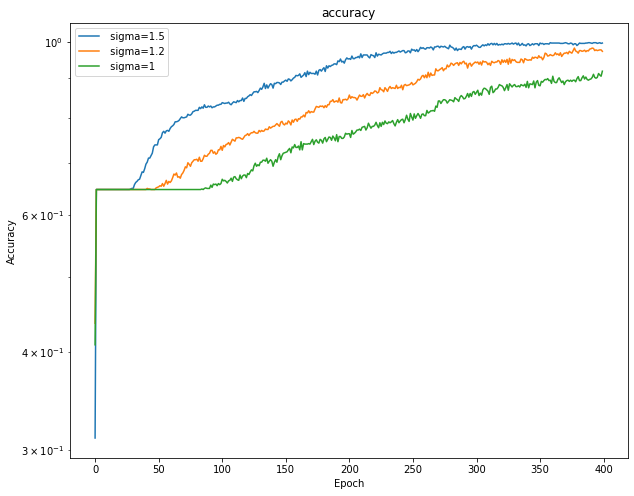

In [ ]:
show_result(foldHist, scores, nmodel, num_epochs)

### FCNN and CNN

In [ ]:
num_epochs = 400

In [ ]:
fcnn_foldperf_400, fcnn_scores_400 = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, sigma=1.5, show=False)

100%|██████████| 80/80 [00:03<00:00, 25.45it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.8134152293205261; sparse_categorical_accuracy of 85.30544638633728%


100%|██████████| 80/80 [00:01<00:00, 55.25it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.6967067122459412; sparse_categorical_accuracy of 86.24105453491211%


100%|██████████| 80/80 [00:01<00:00, 53.67it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.7258000373840332; sparse_categorical_accuracy of 86.1309826374054%


100%|██████████| 80/80 [00:01<00:00, 54.06it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.5628393292427063; sparse_categorical_accuracy of 87.28673458099365%


100%|██████████| 80/80 [00:01<00:00, 54.40it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.6281322836875916; sparse_categorical_accuracy of 86.24105453491211%


100%|██████████| 80/80 [00:01<00:00, 53.57it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.697391927242279; sparse_categorical_accuracy of 85.85580587387085%


100%|██████████| 80/80 [00:01<00:00, 52.50it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.9484433531761169; sparse_categorical_accuracy of 84.14969444274902%


100%|██████████| 80/80 [00:01<00:00, 52.84it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.7193429470062256; sparse_categorical_accuracy of 84.8651647567749%


100%|██████████| 80/80 [00:01<00:00, 53.96it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.6137663722038269; sparse_categorical_accuracy of 87.56191730499268%


100%|██████████| 80/80 [00:01<00:00, 52.22it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.5999865531921387; sparse_categorical_accuracy of 86.63366436958313%


In [ ]:
cnn_foldperf_400, cnn_scores_400 = train_model(cnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.5263264179229736; sparse_categorical_accuracy of 84.53494906425476%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.6121723651885986; sparse_categorical_accuracy of 85.19537448883057%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.7142025828361511; sparse_categorical_accuracy of 82.33351707458496%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 2.32403826713562; sparse_categorical_accuracy of 82.99394845962524%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.7266206741333008; sparse_categorical_accuracy of 83.15905332565308%
-------------------------------------

Performance of 10 fold cross validation
Average model fcnn Loss: 0.701, Average model fcnn Acc: 86.03
Performance of 10 fold cross validation
Average model cnn Loss: 1.675, Average model cnn Acc: 83.77


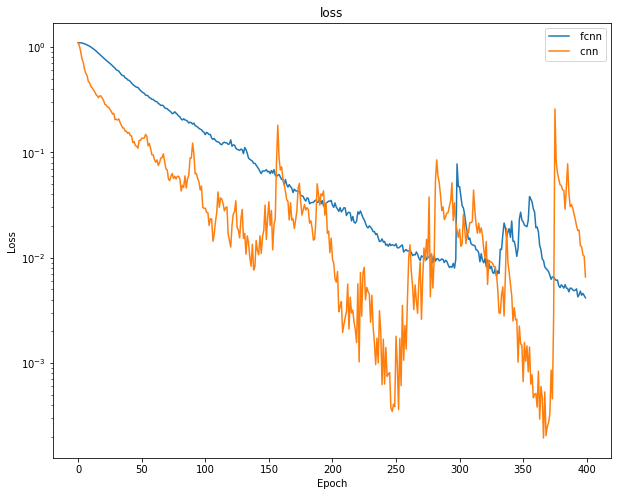

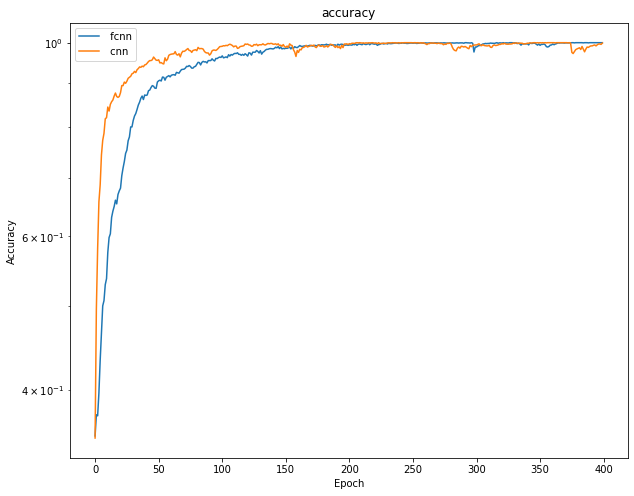

In [ ]:
foldHist =[]
scores = []
foldHist.append(fcnn_foldperf_400)
foldHist.append(cnn_foldperf_400)

scores.append(fcnn_scores_400)
scores.append(cnn_scores_400)

nmodel = [' fcnn', ' cnn']

show_result(foldHist, scores, nmodel, num_epochs)



### different number of neurons

In [ ]:
num_epochs = 150

In [ ]:
n_neurons = 100
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 
out_fRules = random.sample(fRules, n_neurons)
fRules_sigma = K.transpose(out_fRules)

fcnn_foldperf_100n, fcnn_scores_100n = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False)

100%|██████████| 80/80 [00:01<00:00, 51.05it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.7316449880599976; sparse_categorical_accuracy of 73.85321259498596%


100%|██████████| 80/80 [00:01<00:00, 55.23it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.7608943581581116; sparse_categorical_accuracy of 75.2293586730957%


100%|██████████| 80/80 [00:01<00:00, 56.23it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.7077704668045044; sparse_categorical_accuracy of 77.06422209739685%


100%|██████████| 80/80 [00:01<00:00, 55.22it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.8574344515800476; sparse_categorical_accuracy of 75.91742873191833%


100%|██████████| 80/80 [00:01<00:00, 55.54it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.6635116934776306; sparse_categorical_accuracy of 73.85321259498596%


100%|██████████| 80/80 [00:01<00:00, 55.34it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.7910442352294922; sparse_categorical_accuracy of 72.08238244056702%


100%|██████████| 80/80 [00:01<00:00, 55.31it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.792351484298706; sparse_categorical_accuracy of 77.80320644378662%


100%|██████████| 80/80 [00:01<00:00, 55.15it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.7571698427200317; sparse_categorical_accuracy of 70.48054933547974%


100%|██████████| 80/80 [00:01<00:00, 54.58it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.8401696681976318; sparse_categorical_accuracy of 74.59954023361206%


100%|██████████| 80/80 [00:01<00:00, 55.76it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.7012923955917358; sparse_categorical_accuracy of 77.11670398712158%


In [ ]:
n_neurons = 150
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 
out_fRules = random.sample(fRules, n_neurons)
fRules_sigma = K.transpose(out_fRules)

fcnn_foldperf_200n, fcnn_scores_200n = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False)

100%|██████████| 80/80 [00:01<00:00, 51.40it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.8981510400772095; sparse_categorical_accuracy of 70.64220309257507%


100%|██████████| 80/80 [00:01<00:00, 52.86it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.9778382778167725; sparse_categorical_accuracy of 75.68807601928711%


100%|██████████| 80/80 [00:01<00:00, 50.98it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.9241163730621338; sparse_categorical_accuracy of 70.64220309257507%


100%|██████████| 80/80 [00:01<00:00, 53.53it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.94173663854599; sparse_categorical_accuracy of 76.60550475120544%


100%|██████████| 80/80 [00:01<00:00, 53.04it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.0105558633804321; sparse_categorical_accuracy of 77.98165082931519%


100%|██████████| 80/80 [00:01<00:00, 52.05it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.962742805480957; sparse_categorical_accuracy of 75.05720853805542%


100%|██████████| 80/80 [00:01<00:00, 52.00it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.8395112752914429; sparse_categorical_accuracy of 81.69336318969727%


100%|██████████| 80/80 [00:01<00:00, 51.07it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.927760660648346; sparse_categorical_accuracy of 72.99771308898926%


100%|██████████| 80/80 [00:01<00:00, 53.23it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.892096757888794; sparse_categorical_accuracy of 65.21739363670349%


100%|██████████| 80/80 [00:01<00:00, 51.57it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.9036220908164978; sparse_categorical_accuracy of 71.85354828834534%


In [ ]:
n_neurons = 50
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 
out_fRules = random.sample(fRules, n_neurons)
fRules_sigma = K.transpose(out_fRules)

fcnn_foldperf_50n, fcnn_scores_50n = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False)

100%|██████████| 80/80 [00:01<00:00, 58.10it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.9478568434715271; sparse_categorical_accuracy of 75.91742873191833%


100%|██████████| 80/80 [00:01<00:00, 59.26it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.9332692623138428; sparse_categorical_accuracy of 74.7706413269043%


100%|██████████| 80/80 [00:01<00:00, 59.00it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.9304156303405762; sparse_categorical_accuracy of 75.68807601928711%


100%|██████████| 80/80 [00:01<00:00, 59.70it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.9520224928855896; sparse_categorical_accuracy of 73.16513657569885%


100%|██████████| 80/80 [00:01<00:00, 59.61it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.9432494044303894; sparse_categorical_accuracy of 69.95412707328796%


100%|██████████| 80/80 [00:01<00:00, 58.43it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.9876541495323181; sparse_categorical_accuracy of 35.46910881996155%


100%|██████████| 80/80 [00:01<00:00, 59.42it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.9599999785423279; sparse_categorical_accuracy of 69.5652186870575%


100%|██████████| 80/80 [00:01<00:00, 59.18it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.9816029071807861; sparse_categorical_accuracy of 75.97253918647766%


100%|██████████| 80/80 [00:01<00:00, 58.75it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.9221076965332031; sparse_categorical_accuracy of 72.76887893676758%


100%|██████████| 80/80 [00:01<00:00, 58.45it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.9365050792694092; sparse_categorical_accuracy of 45.30892372131348%


Performance of 10 fold cross validation
Average model 100 Loss: 0.760, Average model 100 Acc: 74.80
Performance of 10 fold cross validation
Average model 50 Loss: 0.949, Average model 50 Acc: 66.86
Performance of 10 fold cross validation
Average model 150 Loss: 0.928, Average model 150 Acc: 73.84


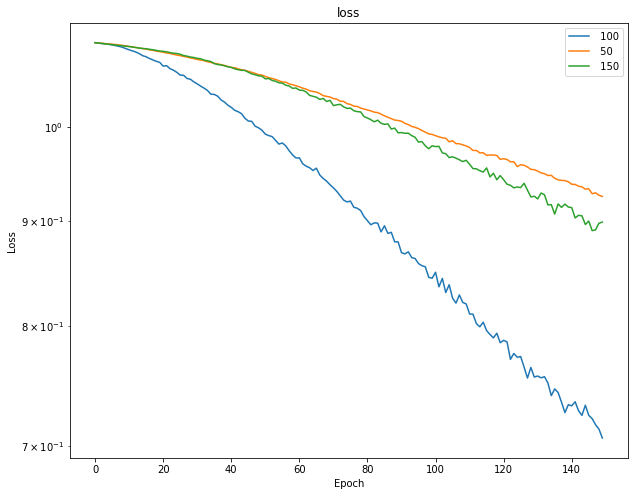

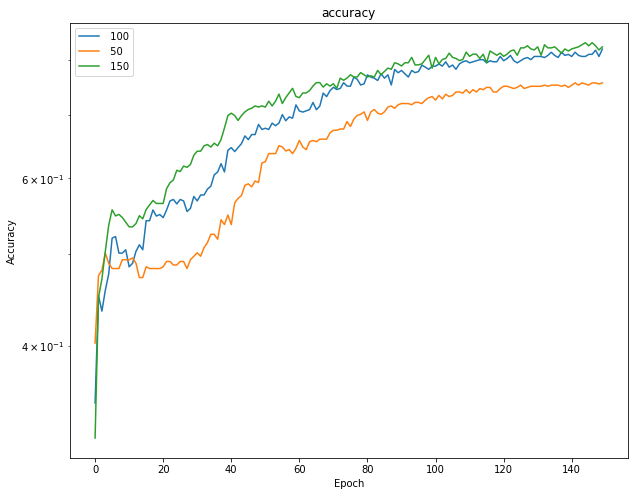

In [ ]:
foldHist =[]
scores = []
foldHist.append(fcnn_foldperf_100n)
foldHist.append(fcnn_foldperf_50n)
foldHist.append(fcnn_foldperf_200n)

scores.append(fcnn_scores_100n)
scores.append(fcnn_scores_50n)
scores.append(fcnn_scores_200n)

nmodel = [' 100', ' 50', ' 150']

show_result(foldHist, scores, nmodel, num_epochs)



### different size of feature map

In [ ]:
num_epochs = 300

In [ ]:
n_feature = 4
n_neurons = 81
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 
out_fRules = random.sample(fRules, n_neurons)
fRules_sigma = K.transpose(out_fRules)

fcnn_foldperf_4nf, fcnn_scores_4nf = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, stride=3, show=False)

100%|██████████| 80/80 [00:01<00:00, 55.35it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.6233118176460266; sparse_categorical_accuracy of 85.19675135612488%


100%|██████████| 80/80 [00:01<00:00, 58.25it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.7038882970809937; sparse_categorical_accuracy of 85.07183194160461%


100%|██████████| 80/80 [00:01<00:00, 60.14it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.656177282333374; sparse_categorical_accuracy of 86.25859022140503%


100%|██████████| 80/80 [00:01<00:00, 59.21it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.6625794172286987; sparse_categorical_accuracy of 85.19675135612488%


100%|██████████| 80/80 [00:01<00:00, 57.29it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.5911374092102051; sparse_categorical_accuracy of 86.3835096359253%


100%|██████████| 80/80 [00:01<00:00, 58.80it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.733250081539154; sparse_categorical_accuracy of 84.3222975730896%


100%|██████████| 80/80 [00:01<00:00, 57.44it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.5463449954986572; sparse_categorical_accuracy of 85.00936627388%


100%|██████████| 80/80 [00:01<00:00, 56.50it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.7218306660652161; sparse_categorical_accuracy of 85.38413643836975%


100%|██████████| 80/80 [00:01<00:00, 58.35it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 1.0708626508712769; sparse_categorical_accuracy of 82.19862580299377%


100%|██████████| 80/80 [00:01<00:00, 57.81it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.5318368077278137; sparse_categorical_accuracy of 88.13982605934143%


In [ ]:
n_feature = 9
n_neurons = 81

fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 
out_fRules = random.sample(fRules, n_neurons)
fRules_sigma = K.transpose(out_fRules)

fcnn_foldperf_9nf, fcnn_scores_9nf = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, stride=2, show=False)

100%|██████████| 80/80 [00:01<00:00, 57.64it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4167550206184387; sparse_categorical_accuracy of 86.07120513916016%


100%|██████████| 80/80 [00:01<00:00, 56.55it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.4449249804019928; sparse_categorical_accuracy of 82.63584971427917%


100%|██████████| 80/80 [00:01<00:00, 56.49it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.39861825108528137; sparse_categorical_accuracy of 85.69644093513489%


100%|██████████| 80/80 [00:01<00:00, 55.99it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.418630987405777; sparse_categorical_accuracy of 84.69706177711487%


100%|██████████| 80/80 [00:01<00:00, 56.95it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.39125683903694153; sparse_categorical_accuracy of 86.57089471817017%


100%|██████████| 80/80 [00:01<00:00, 56.42it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.4147685766220093; sparse_categorical_accuracy of 84.94690656661987%


100%|██████████| 80/80 [00:01<00:00, 55.81it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.37694209814071655; sparse_categorical_accuracy of 86.94565892219543%


100%|██████████| 80/80 [00:01<00:00, 57.37it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.45145606994628906; sparse_categorical_accuracy of 82.38601088523865%


100%|██████████| 80/80 [00:01<00:00, 57.79it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.46328869462013245; sparse_categorical_accuracy of 83.82260799407959%


100%|██████████| 80/80 [00:02<00:00, 38.25it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.43224507570266724; sparse_categorical_accuracy of 83.70786309242249%


Performance of 10 fold cross validation
Average model 4 nf Loss: 0.684, Average model 4 nf Acc: 85.32
Performance of 10 fold cross validation
Average model 9 nf Loss: 0.421, Average model 9 nf Acc: 84.75


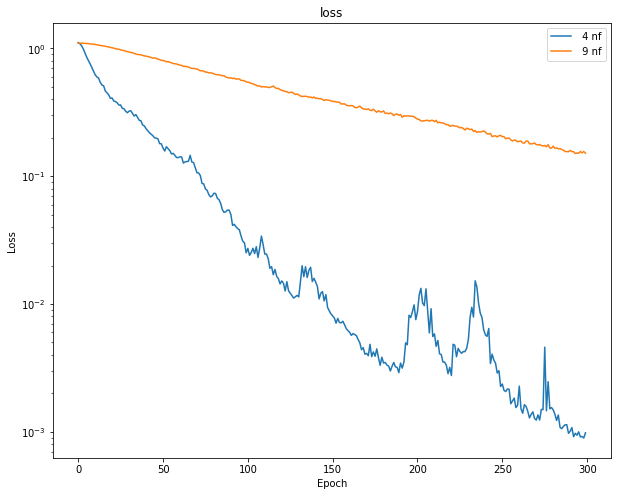

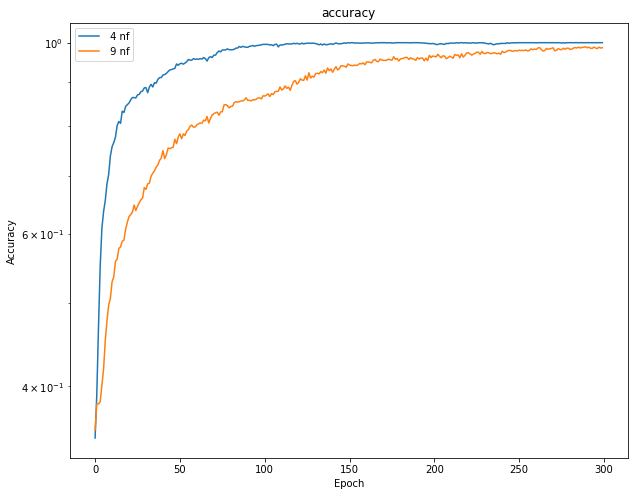

In [ ]:
foldHist =[]
scores = []
foldHist.append(fcnn_foldperf_4nf)
foldHist.append(fcnn_foldperf_9nf)

scores.append(fcnn_scores_4nf)
scores.append(fcnn_scores_9nf)

nmodel = [' 4 nf', ' 9 nf']

show_result(foldHist, scores, nmodel, num_epochs)



### different optimizer

In [ ]:
num_epochs = 200

In [ ]:
fcnn_foldperf_sgd, fcnn_scores_sgd = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False, optimizer='Adagrad')

100%|██████████| 80/80 [00:01<00:00, 52.77it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.0982156991958618; sparse_categorical_accuracy of 34.61750149726868%


100%|██████████| 80/80 [00:01<00:00, 56.49it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.0981390476226807; sparse_categorical_accuracy of 34.067144989967346%


100%|██████████| 80/80 [00:01<00:00, 57.11it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1.0978288650512695; sparse_categorical_accuracy of 34.56246554851532%


100%|██████████| 80/80 [00:01<00:00, 57.26it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 1.098490595817566; sparse_categorical_accuracy of 34.61750149726868%


100%|██████████| 80/80 [00:01<00:00, 57.85it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.0983778238296509; sparse_categorical_accuracy of 34.56246554851532%


100%|██████████| 80/80 [00:01<00:00, 56.06it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 1.0978219509124756; sparse_categorical_accuracy of 34.39735770225525%


100%|██████████| 80/80 [00:01<00:00, 55.99it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 1.0994929075241089; sparse_categorical_accuracy of 34.39735770225525%


100%|██████████| 80/80 [00:01<00:00, 55.51it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 1.0977541208267212; sparse_categorical_accuracy of 34.50742959976196%


100%|██████████| 80/80 [00:01<00:00, 53.45it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 1.0983833074569702; sparse_categorical_accuracy of 34.34232175350189%


100%|██████████| 80/80 [00:01<00:00, 54.84it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 1.0980736017227173; sparse_categorical_accuracy of 34.54345464706421%


In [ ]:
fcnn_foldperf_adam, fcnn_scores_adam = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False, optimizer='adam')


100%|██████████| 80/80 [00:01<00:00, 55.25it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4364187717437744; sparse_categorical_accuracy of 86.24105453491211%


100%|██████████| 80/80 [00:01<00:00, 55.39it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.3814060091972351; sparse_categorical_accuracy of 86.1309826374054%


100%|██████████| 80/80 [00:01<00:00, 56.32it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.4431970715522766; sparse_categorical_accuracy of 80.95762133598328%


100%|██████████| 80/80 [00:01<00:00, 56.24it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.4765640199184418; sparse_categorical_accuracy of 85.85580587387085%


100%|██████████| 80/80 [00:01<00:00, 56.40it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.4115653932094574; sparse_categorical_accuracy of 85.25041341781616%


100%|██████████| 80/80 [00:01<00:00, 56.20it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.4633503258228302; sparse_categorical_accuracy of 83.43423008918762%


100%|██████████| 80/80 [00:01<00:00, 57.00it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.4073933959007263; sparse_categorical_accuracy of 84.97523665428162%


100%|██████████| 80/80 [00:01<00:00, 55.00it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.4825027883052826; sparse_categorical_accuracy of 86.51623725891113%


100%|██████████| 80/80 [00:01<00:00, 55.07it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.46497076749801636; sparse_categorical_accuracy of 83.98458957672119%


100%|██████████| 80/80 [00:01<00:00, 56.08it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.45411667227745056; sparse_categorical_accuracy of 85.42354106903076%


Performance of 10 fold cross validation
Average model sgd Loss: 1.098, Average model sgd Acc: 34.46
Performance of 10 fold cross validation
Average model Adagrad Loss: 0.442, Average model Adagrad Acc: 84.88


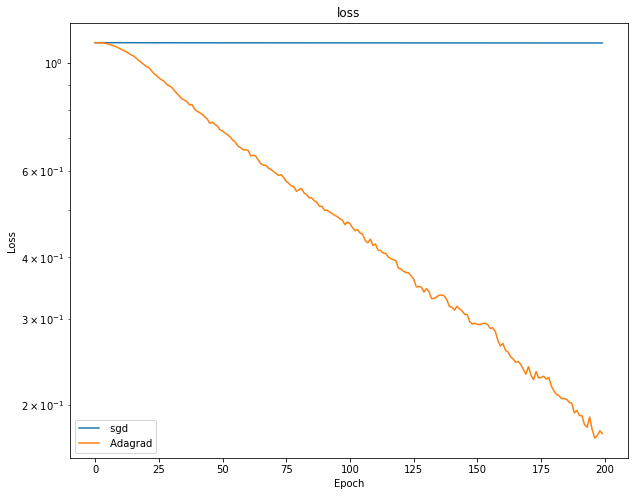

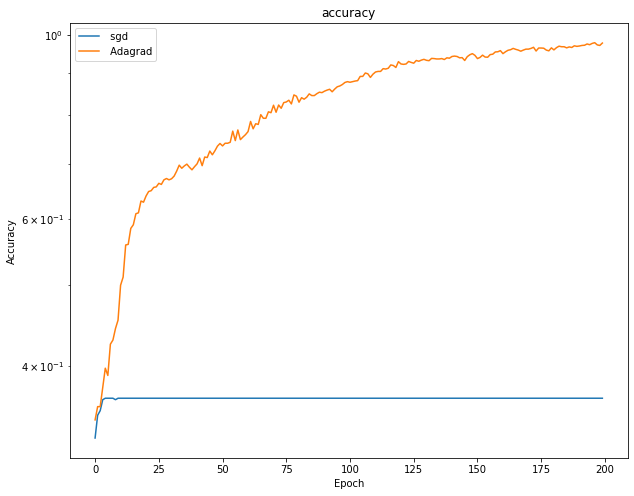

In [ ]:
foldHist =[]
scores = []
foldHist.append(fcnn_foldperf_sgd)
foldHist.append(fcnn_foldperf_adam)

scores.append(fcnn_scores_sgd)
scores.append(fcnn_scores_adam)

nmodel = [' sgd', ' Adagrad']

show_result(foldHist, scores, nmodel, num_epochs)



### Dropout or not

In [17]:
num_epochs = 200

In [18]:
fcnn_foldperf_dropout, fcnn_scores_dropout = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False, dropout=True)

100%|██████████| 80/80 [00:01<00:00, 68.42it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.49821099638938904; sparse_categorical_accuracy of 83.70941281318665%


100%|██████████| 80/80 [00:01<00:00, 74.39it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.5079297423362732; sparse_categorical_accuracy of 85.5806291103363%


100%|██████████| 80/80 [00:01<00:00, 65.31it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5094882249832153; sparse_categorical_accuracy of 83.54430198669434%


100%|██████████| 80/80 [00:01<00:00, 72.51it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.4952751100063324; sparse_categorical_accuracy of 82.71876573562622%


100%|██████████| 80/80 [00:01<00:00, 68.50it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.612217366695404; sparse_categorical_accuracy of 80.13208508491516%


100%|██████████| 80/80 [00:01<00:00, 70.61it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.47420910000801086; sparse_categorical_accuracy of 85.08530259132385%


100%|██████████| 80/80 [00:01<00:00, 66.00it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.5607860088348389; sparse_categorical_accuracy of 85.25041341781616%


100%|██████████| 80/80 [00:01<00:00, 70.39it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.6392046809196472; sparse_categorical_accuracy of 61.860209703445435%


100%|██████████| 80/80 [00:01<00:00, 64.16it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.419354110956192; sparse_categorical_accuracy of 86.40616536140442%


100%|██████████| 80/80 [00:01<00:00, 68.63it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.48460155725479126; sparse_categorical_accuracy of 80.69307208061218%


In [19]:
fcnn_foldperf_nodropout, fcnn_scores_nodropout = train_model(fcnn, normalized_train_images, train_labels,no_epochs=num_epochs, show=False, dropout=False)


100%|██████████| 80/80 [00:01<00:00, 66.88it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.41163527965545654; sparse_categorical_accuracy of 86.79141402244568%


100%|██████████| 80/80 [00:01<00:00, 67.03it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.435920774936676; sparse_categorical_accuracy of 85.415518283844%


100%|██████████| 80/80 [00:01<00:00, 63.57it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.39732497930526733; sparse_categorical_accuracy of 86.1309826374054%


100%|██████████| 80/80 [00:01<00:00, 64.54it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.4455275237560272; sparse_categorical_accuracy of 85.08530259132385%


100%|██████████| 80/80 [00:01<00:00, 67.24it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.36778801679611206; sparse_categorical_accuracy of 86.51623725891113%


100%|██████████| 80/80 [00:01<00:00, 71.94it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.4344778060913086; sparse_categorical_accuracy of 85.14034152030945%


100%|██████████| 80/80 [00:01<00:00, 65.36it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.4308285713195801; sparse_categorical_accuracy of 85.19537448883057%


100%|██████████| 80/80 [00:01<00:00, 67.02it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.39110440015792847; sparse_categorical_accuracy of 86.1309826374054%


100%|██████████| 80/80 [00:01<00:00, 75.29it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.41046833992004395; sparse_categorical_accuracy of 85.19537448883057%


100%|██████████| 80/80 [00:01<00:00, 67.35it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.3933229446411133; sparse_categorical_accuracy of 87.01870441436768%


Performance of 10 fold cross validation
Average model dropout Loss: 0.520, Average model dropout Acc: 81.50
Performance of 10 fold cross validation
Average model no dropout Loss: 0.412, Average model no dropout Acc: 85.86


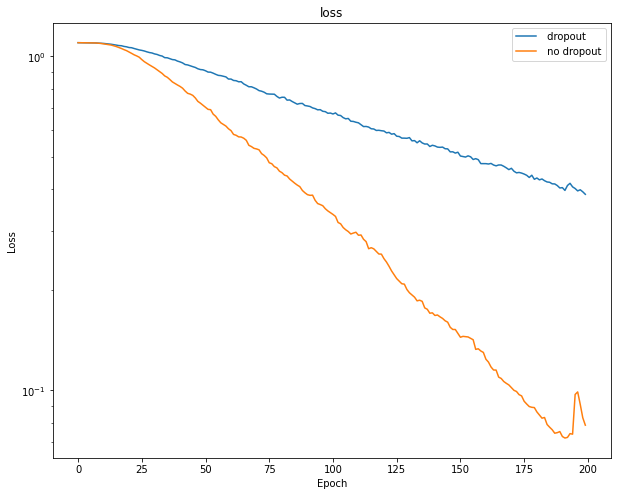

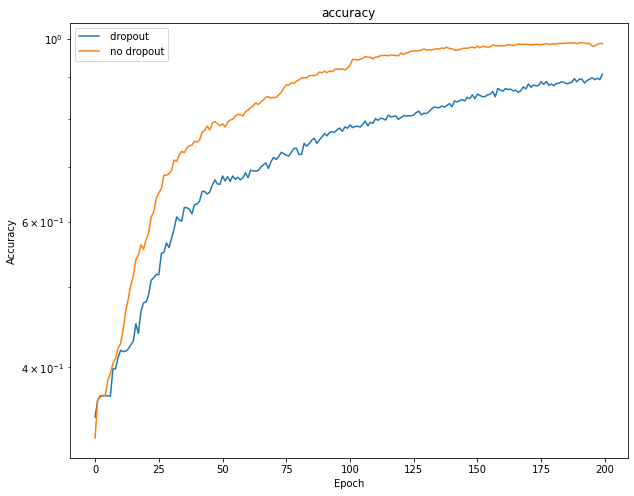

In [20]:
foldHist =[]
scores = []
foldHist.append(fcnn_foldperf_dropout)
foldHist.append(fcnn_foldperf_nodropout)

scores.append(fcnn_scores_dropout)
scores.append(fcnn_scores_nodropout)

nmodel = [' dropout', ' no dropout']

show_result(foldHist, scores, nmodel, num_epochs)

